# 📊 Анализ ML-проверенных транзакций

Сравниваем FRAUD vs NON-FRAUD транзакции, которые прошли через scorecard фильтр

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Загрузка данных

In [2]:
# Загружаем ТОЛЬКО ML-проверенные транзакции (те, что прошли через scorecard)
ml_checked = pd.read_csv("../docs/ml_checked_transactions.csv")

print(f"📊 ML-Checked Transactions: {len(ml_checked)}")
print(f"\nColumns: {list(ml_checked.columns)}")

if 'target' in ml_checked.columns:
    fraud_count = ml_checked['target'].sum()
    non_fraud_count = len(ml_checked) - fraud_count
    print(f"\n🎯 Target distribution:")
    print(f"   Fraud (target=1): {fraud_count} ({fraud_count/len(ml_checked)*100:.1f}%)")
    print(f"   Non-Fraud (target=0): {non_fraud_count} ({non_fraud_count/len(ml_checked)*100:.1f}%)")

ml_checked.head()

📊 ML-Checked Transactions: 233

Columns: ['cst_dim_id', 'transdate', 'transdatetime', 'amount', 'docno', 'direction', 'target', 'os_count_30d', 'Количество разных моделей телефона (phone_model) за последние 30 дней — насколько часто клиент “менял устройство” по логам', 'last_phone_model', 'last_os_ver', 'logins_7d', 'Количество уникальных логин-сессий за последние 30 дней до transdate', 'avg_logins_7d', 'avg_logins_30d', 'rel_freq_change_7_30d', 'login_share_7_30d', 'avg_login_interval', 'std_login_interval', 'interval_variance_30d', 'weighted_avg_interval_7d', 'Показатель “взрывности” логинов: (std?mean)/(std+mean)(std - mean)/(std + mean)(std?mean)/(std+mean) для интервалов', 'fano_factor_interval', 'z_score_avg_interval_7d_vs_30d', 'hour', 'day_of_week', 'is_night', 'amount_log', 'is_high_risk_combo', 'is_fast_bot', 'time_since_last_login', 'user_avg_amt', 'user_std_amt', 'user_tx_count', 'user_hist_fraud', 'amount_to_avg_ratio', 'rare_os_flag', 'rare_device_flag', 'high_device_vola

,cst_dim_id,transdate,transdatetime,amount,docno,direction,target,os_count_30d,Количество разных моделей телефона (phone_model) за последние 30 дней — насколько часто клиент “менял устройство” по логам,last_phone_model,...,suspicious_device_combo,high_login_volatility,scorecard_total,device_count_30d,login_volatility_factor,is_device_hopper,fraud_probability,fraud_prediction,risk_level,detection_stage
0,452951313,2025-07-05,2025-07-05 14:49:58,30000.0,1230,284f2dfd6013a7a30a5942eec5fa41a2,0,1.0,1,"iPhone10,5",...,0,0,4,0,0,0,0.000012,0,LOW,ml_model
1,456175450,2025-06-19,2025-06-19 21:26:36,20000.0,17,8af822d1743890a91682fc1283abac85,0,3.0,2,x86_64,...,0,0,4,0,0,0,0.000123,0,LOW,ml_model
2,2684371840,2025-05-15,2025-05-15 19:29:16,3000.0,7547,49bd05dbeb272e3330af9d0fb3787021,0,1.0,1,"iPhone10,4",...,0,0,4,0,0,0,0.000018,0,LOW,ml_model
3,2938439602,2025-02-15,2025-02-15 17:06:26,10000.0,8865,02586bb1848d5befd6641a472404c96f,0,1.0,2,implyForteApp 1.0 Samsung_sm-a125,...,0,0,4,0,0,0,0.000031,0,LOW,ml_model
4,452951313,2025-05-08,2025-05-08 20:38:52,6000.0,6549,5ee368e719289d181e38968224ef60db,0,2.0,1,"iPhone10,5",...,0,0,4,0,0,0,0.000002,0,LOW,ml_model


## 2. Сравнение Scorecard фичей: FRAUD vs NON-FRAUD

Available scorecard features: ['scorecard_total', 'rare_os_flag', 'rare_device_flag', 'suspicious_device_combo', 'high_device_volatility', 'high_login_volatility']

📋 Feature Comparison (Mean values):
                         Non-Fraud  Fraud  Diff_Ratio
scorecard_total                4.0    4.0         1.0
rare_os_flag                   1.0    1.0         1.0
rare_device_flag               1.0    1.0         1.0
suspicious_device_combo        0.0    0.0         0.0
high_device_volatility         0.0    0.0         0.0
high_login_volatility          0.0    0.0         0.0


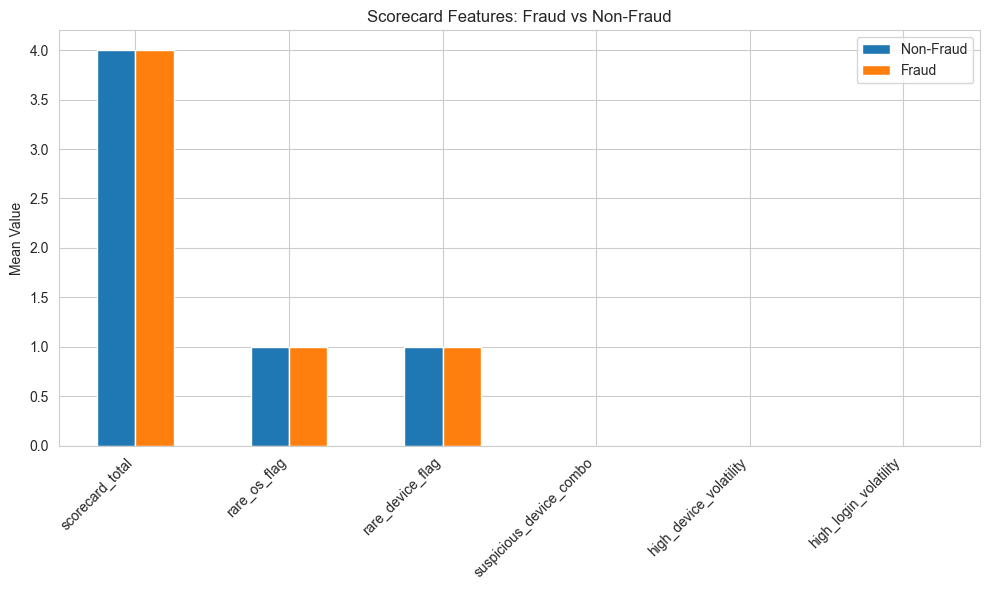

In [3]:
# Scorecard фичи для анализа
scorecard_features = [
    'scorecard_total',
    'rare_os_flag',
    'rare_device_flag',
    'suspicious_device_combo',
    'high_device_volatility',
    'high_login_volatility'
]

# Фильтруем только те, что есть
available_features = [f for f in scorecard_features if f in ml_checked.columns]
print(f"Available scorecard features: {available_features}")

if 'target' in ml_checked.columns and available_features:
    # Сравнение средних значений
    comparison = ml_checked.groupby('target')[available_features].mean().T
    comparison.columns = ['Non-Fraud', 'Fraud']
    comparison['Diff_Ratio'] = comparison['Fraud'] / (comparison['Non-Fraud'] + 1e-9)
    comparison = comparison.sort_values('Diff_Ratio', ascending=False)
    
    print("\n📋 Feature Comparison (Mean values):")
    print(comparison)
    
    # Визуализация
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    comparison[['Non-Fraud', 'Fraud']].plot(kind='bar', ax=ax)
    plt.title('Scorecard Features: Fraud vs Non-Fraud')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 3. Анализ ML-предсказаний

🤖 ML Model Performance (on ML-checked transactions only):

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00       225
       Fraud       1.00      1.00      1.00         8

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233


Confusion Matrix:
TN: 225 | FP: 0
FN: 0 | TP: 8


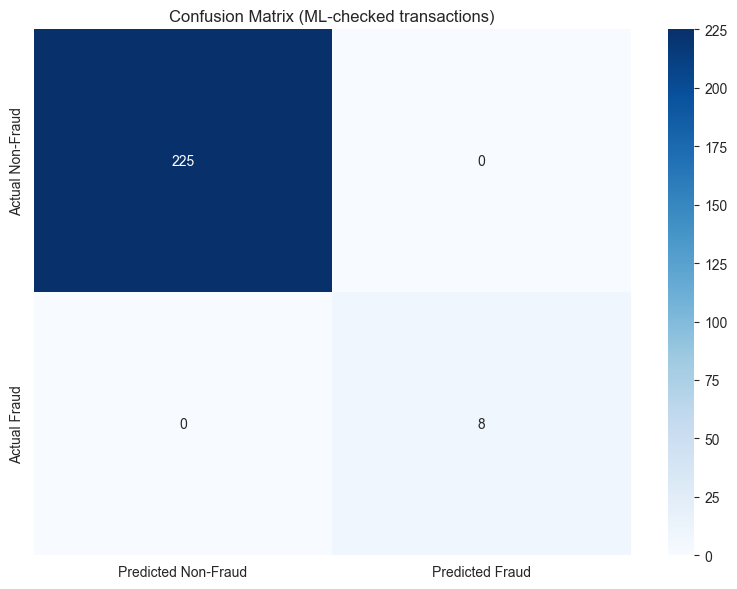

In [4]:
# Проверяем качество предсказаний модели
if 'target' in ml_checked.columns and 'fraud_prediction' in ml_checked.columns:
    from sklearn.metrics import classification_report, confusion_matrix
    
    print("🤖 ML Model Performance (on ML-checked transactions only):")
    print("\nClassification Report:")
    print(classification_report(ml_checked['target'], ml_checked['fraud_prediction'], 
                                target_names=['Non-Fraud', 'Fraud']))
    
    # Confusion Matrix
    cm = confusion_matrix(ml_checked['target'], ml_checked['fraud_prediction'])
    print("\nConfusion Matrix:")
    print(f"TN: {cm[0,0]} | FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]} | TP: {cm[1,1]}")
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
                yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
    plt.title('Confusion Matrix (ML-checked transactions)')
    plt.tight_layout()
    plt.show()

## 4. Детальный анализ FALSE NEGATIVES (пропущенные фроды)

In [5]:
# Анализируем транзакции, где модель ошиблась
if 'target' in ml_checked.columns and 'fraud_prediction' in ml_checked.columns:
    # False Negatives (реальный фрод, но модель не поймала)
    false_negatives = ml_checked[(ml_checked['target'] == 1) & (ml_checked['fraud_prediction'] == 0)]
    
    # True Positives (правильно определили фрод)
    true_positives = ml_checked[(ml_checked['target'] == 1) & (ml_checked['fraud_prediction'] == 1)]
    
    print(f"\n🔍 Analysis of MISSED FRAUDS (False Negatives):")
    print(f"   Total missed: {len(false_negatives)}")
    
    if len(false_negatives) > 0 and len(true_positives) > 0:
        print("\n📊 Comparing MISSED vs DETECTED frauds:")
        
        comparison_cols = available_features + ['fraud_probability']
        comparison_cols = [c for c in comparison_cols if c in ml_checked.columns]
        
        fn_stats = false_negatives[comparison_cols].mean()
        tp_stats = true_positives[comparison_cols].mean()
        
        comparison_df = pd.DataFrame({
            'Missed_Fraud': fn_stats,
            'Detected_Fraud': tp_stats
        })
        comparison_df['Difference'] = comparison_df['Detected_Fraud'] - comparison_df['Missed_Fraud']
        
        print(comparison_df)
        
        # Показываем примеры пропущенных фродов
        print("\n❌ Examples of MISSED frauds:")
        display_cols = ['scorecard_total', 'fraud_probability'] + available_features[:3]
        display_cols = [c for c in display_cols if c in false_negatives.columns]
        print(false_negatives[display_cols].head())
    else:
        print("   ✅ No false negatives or no true positives to compare!")


🔍 Analysis of MISSED FRAUDS (False Negatives):
   Total missed: 0
   ✅ No false negatives or no true positives to compare!


## 5. Распределение Scorecard Score по категориям

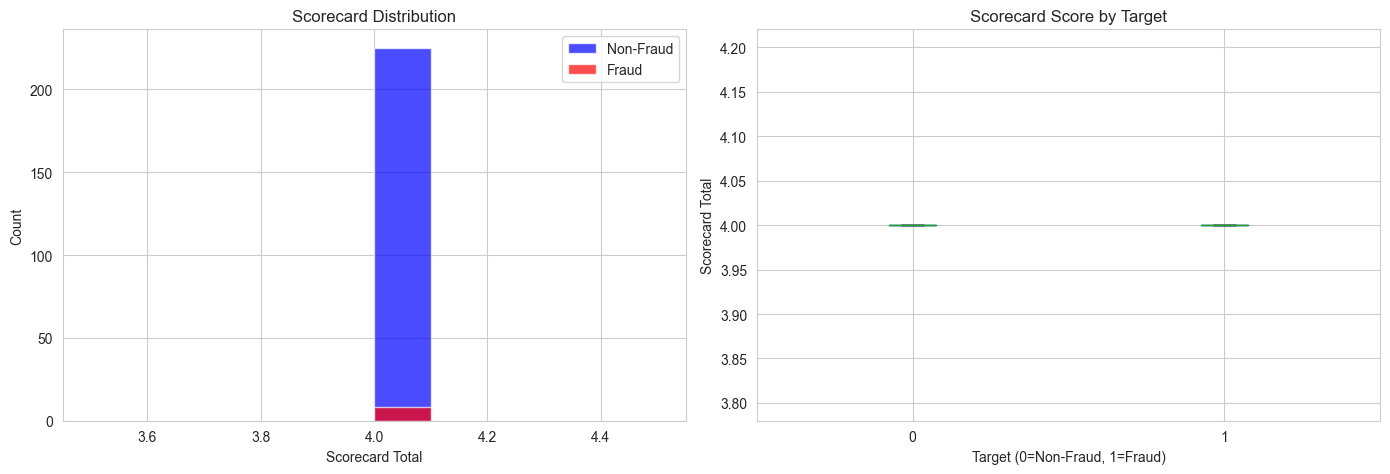


📊 Fraud rate by Scorecard Score:
                 Fraud_Count  Total_Count  Fraud_Rate
scorecard_total                                      
4                          8          233    3.433476


In [6]:
# Анализ распределения scorecard_total
if 'scorecard_total' in ml_checked.columns and 'target' in ml_checked.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ml_checked[ml_checked['target'] == 0]['scorecard_total'].hist(ax=axes[0], bins=10, alpha=0.7, label='Non-Fraud', color='blue')
    ml_checked[ml_checked['target'] == 1]['scorecard_total'].hist(ax=axes[0], bins=10, alpha=0.7, label='Fraud', color='red')
    axes[0].set_xlabel('Scorecard Total')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Scorecard Distribution')
    axes[0].legend()
    
    # Boxplot
    ml_checked.boxplot(column='scorecard_total', by='target', ax=axes[1])
    axes[1].set_xlabel('Target (0=Non-Fraud, 1=Fraud)')
    axes[1].set_ylabel('Scorecard Total')
    axes[1].set_title('Scorecard Score by Target')
    plt.suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    # Статистика по группам scorecard
    print("\n📊 Fraud rate by Scorecard Score:")
    fraud_by_score = ml_checked.groupby('scorecard_total')['target'].agg(['sum', 'count', 'mean'])
    fraud_by_score.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
    fraud_by_score['Fraud_Rate'] = fraud_by_score['Fraud_Rate'] * 100
    print(fraud_by_score)

## 6. Выводы и рекомендации

In [7]:
print("\n" + "="*60)
print("🎯 KEY FINDINGS")
print("="*60)

if 'target' in ml_checked.columns:
    # 1. Scorecard эффективность
    print("\n1. SCORECARD FILTER EFFECTIVENESS:")
    total_transactions = 13140  # из терминала
    ml_check_rate = len(ml_checked) / total_transactions * 100
    print(f"   - Only {ml_check_rate:.1f}% of transactions need ML check")
    print(f"   - {100-ml_check_rate:.1f}% auto-approved (huge performance gain!)")
    
    # 2. ML модель на отфильтрованных
    if 'fraud_prediction' in ml_checked.columns:
        from sklearn.metrics import precision_score, recall_score, f1_score
        precision = precision_score(ml_checked['target'], ml_checked['fraud_prediction'])
        recall = recall_score(ml_checked['target'], ml_checked['fraud_prediction'])
        f1 = f1_score(ml_checked['target'], ml_checked['fraud_prediction'])
        
        print("\n2. ML MODEL PERFORMANCE (on suspicious transactions):")
        print(f"   - Precision: {precision:.2f}")
        print(f"   - Recall: {recall:.2f}")
        print(f"   - F1-Score: {f1:.2f}")
    
    # 3. Рекомендации
    print("\n3. RECOMMENDATIONS:")
    if len(false_negatives) > 0:
        print(f"   ⚠️ Found {len(false_negatives)} missed frauds - analyze their patterns!")
        print("   💡 Consider adding more features to scorecard or lowering threshold")
    else:
        print("   ✅ No missed frauds in this batch!")
    
    print("\n" + "="*60)


🎯 KEY FINDINGS

1. SCORECARD FILTER EFFECTIVENESS:
   - Only 1.8% of transactions need ML check
   - 98.2% auto-approved (huge performance gain!)

2. ML MODEL PERFORMANCE (on suspicious transactions):
   - Precision: 1.00
   - Recall: 1.00
   - F1-Score: 1.00

3. RECOMMENDATIONS:
   ✅ No missed frauds in this batch!



In [ ]:
dff = pd.read_csv("../docs/транзакции в Мобильном интернет Банкинге.csv")
pd.